In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
train = pd.read_csv("/Users/radhikapanchal/Downloads/train_data.csv")
test = pd.read_csv('/Users/radhikapanchal/Downloads/test_points.csv')
import warnings  
warnings.filterwarnings("ignore")

# Check for invalid latitudes and longitudes
invalid_lat_long = train[(train['Lat'] < -90) | (train['Lat'] > 90) | (train['Long_'] < -180) | (train['Long_'] > 180)]
print("Invalid Latitude/Longitude:")
print(invalid_lat_long)

# Remove invalid rows
train = train[(train['Lat'] >= -90) & (train['Lat'] <= 90) & (train['Long_'] >= -180) & (train['Long_'] <= 180)]

# Load data
train = train.dropna(subset=['Lat', 'Long_'])
test = test.dropna(subset=['Lat', 'Long_'])

cfr = train['Case_Fatality_Ratio']

mean_cfr = np.mean(cfr)
sd_cfr = np.std(cfr)

lower_limit_mean_sd_cfr = mean_cfr - 3 * sd_cfr
upper_limit_mean_sd_cfr = mean_cfr + 3 * sd_cfr
outliers_mean_sd_cfr = cfr[(cfr < lower_limit_mean_sd_cfr) | (cfr > upper_limit_mean_sd_cfr)]
print(outliers_mean_sd_cfr)
cfr_no_outliers = cfr[(cfr >= lower_limit_mean_sd_cfr) & (cfr <= upper_limit_mean_sd_cfr)]
train = train[(train['Case_Fatality_Ratio'] >= lower_limit_mean_sd_cfr) & (train['Case_Fatality_Ratio'] <= upper_limit_mean_sd_cfr)]

# Feature Engineering
train['region'] = (train['Lat'] // 10).astype(int)  # Example: Grouping by region
test['region'] = (test['Lat'] // 10).astype(int)

train['Distance_Equator'] = np.abs(train['Lat'])
test['Distance_Equator'] = np.abs(test['Lat'])

#train['Case_Fatality_Ratio'] = np.log1p(train['Case_Fatality_Ratio'])  # log1p(x) = log(1 + x), handles zeros

train['Lat_Long_Interaction'] = train['Lat'] * train['Long_']
test['Lat_Long_Interaction'] = test['Lat'] * test['Long_']


Invalid Latitude/Longitude:
Empty DataFrame
Columns: [Lat, Long_, Deaths, Case_Fatality_Ratio]
Index: []
367    600.000000
461    135.795708
Name: Case_Fatality_Ratio, dtype: float64


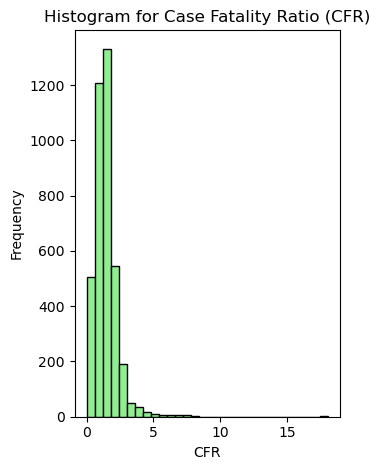

In [47]:
# histogram for Case Fatality Ratio (CFR)
plt.subplot(1, 2, 2)
plt.hist(train['Case_Fatality_Ratio'], bins=30, color="lightgreen", edgecolor="black")
plt.title("Histogram for Case Fatality Ratio (CFR)")
plt.xlabel("CFR")
plt.ylabel("Frequency")

# Display the histograms
plt.tight_layout()
plt.show()

In [48]:
#geographical scatter plot
import plotly.express as px

# Create a DataFrame with lat and long
points_df = train[['Lat', 'Long_']]

# Plot using Plotlyx
fig = px.scatter_geo(points_df, lat='Lat', lon='Long_',
                     title="Geographical Plot of Points",
                     projection='natural earth')

fig.show()

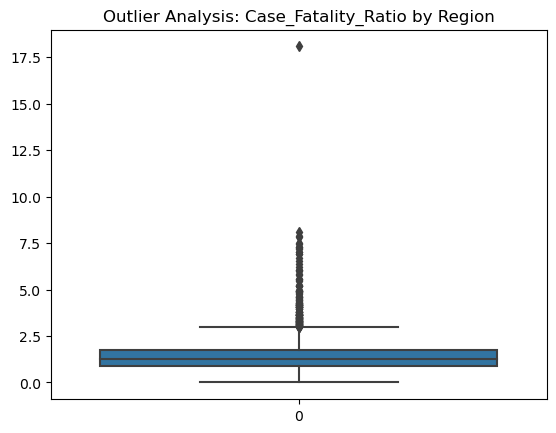

In [49]:
#  box plot for Case Fatality Ratio (CFR)
sns.boxplot(data=train['Case_Fatality_Ratio'])
plt.title("Outlier Analysis: Case_Fatality_Ratio by Region")
plt.show()

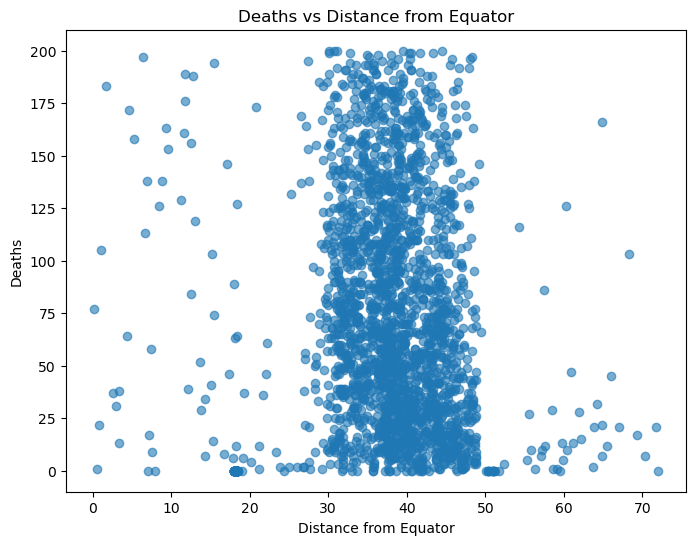

In [50]:
train['Distance_Equator'] = np.abs(train['Lat'])
test['Distance_Equator'] = np.abs(test['Lat'])

plt.figure(figsize=(8, 6))
plt.scatter(train['Distance_Equator'], train['Deaths'], alpha=0.6)
plt.title("Deaths vs Distance from Equator")
plt.xlabel("Distance from Equator")
plt.ylabel("Deaths")
plt.show()

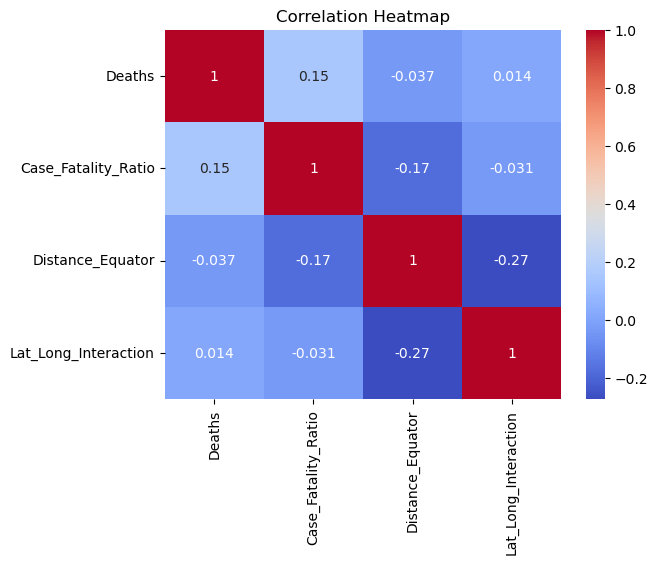

In [51]:

corr = train[['Deaths', 'Case_Fatality_Ratio', 'Distance_Equator', 'Lat_Long_Interaction']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [52]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# ---------------------------- #
#    DATA PREPARATION          #
# ---------------------------- #

# Select features for imputation
features_used = ['Lat', 'Long_','Lat_Long_Interaction','Case_Fatality_Ratio', 'region']



# Separate rows with and without missing Deaths
train_known = train.dropna(subset=['Deaths'])
train_missing = train[train['Deaths'].isna()]

# Features & target
X_known = train_known[features_used]
y_known = train_known['Deaths']

# ---------------------------- #
#  TRAIN FINAL XGBOOST MODEL   #
# ---------------------------- #

# Initialize XGBoost with optimized parameters
xgb_optimized = XGBRegressor(
    subsample=1.0,
    reg_lambda=1,
    reg_alpha=1,
    n_estimators=500,
    min_child_weight=1,
    max_depth=5,
    learning_rate=0.01,
    colsample_bytree=0.6,
    booster='gbtree',
    random_state=42
)

# Train model on known deaths
xgb_optimized.fit(X_known, y_known)

# Predict missing `Deaths` values
train.loc[train['Deaths'].isna(), 'Deaths'] = xgb_optimized.predict(train_missing[features_used])

print(f"✅ Missing values in Deaths after Optimized XGBoost Imputation: {train['Deaths'].isnull().sum()}")

# 🚀 Round Deaths to ensure integer values
train['Deaths'] = train['Deaths'].round().astype(int)

# 🚀 Print value counts of Deaths
print(train['Deaths'].value_counts())


✅ Missing values in Deaths after Optimized XGBoost Imputation: 0
Deaths
0      113
91      44
108     44
96      42
115     42
      ... 
188      3
186      2
195      2
190      1
175      1
Name: count, Length: 201, dtype: int64


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# ---------------------------- #
#        DATA PREPARATION       #
# ---------------------------- #


# Select features and target
features_deaths = ['Lat', 'Long_']
X_deaths = train.dropna(subset=['Deaths'])[features_deaths]
y_deaths = train.dropna(subset=['Deaths'])['Deaths']

# Train-test split
X_train_deaths, X_val_deaths, y_train_deaths, y_val_deaths = train_test_split(
    X_deaths, y_deaths, test_size=0.2, random_state=42
)

# ---------------------------- #
#      OPTIMIZED LIGHTGBM      #
# ---------------------------- #

# Optimized LightGBM Model
lgb = LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.03, 
    max_depth=5, 
    num_leaves=50, 
    min_child_samples=10, 
    lambda_l1=0.5, 
    lambda_l2=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    random_state=42
)

# Train LightGBM Model
lgb.fit(X_train_deaths, y_train_deaths)

# ---------------------------- #
#       MODEL EVALUATION       #
# ---------------------------- #

# Evaluate LightGBM model
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))


    print(f"\n{model_name} Model:")
    print(f"  - Training RMSE: {train_rmse:.4f}")
    print(f"  - Validation RMSE: {val_rmse:.4f}")
    
    return val_rmse

# Evaluate LightGBM Model
print("\n🔹 LightGBM Model Performance:")
lgb_rmse = evaluate_model(lgb, X_train_deaths, X_val_deaths, y_train_deaths, y_val_deaths, "LightGBM")

# ---------------------------- #
#       MAKE PREDICTIONS       #
# ---------------------------- #

# Predict Deaths for test data
test['Deaths'] = np.round(lgb.predict(test[features_deaths]))

# Save predictions
deaths_output_path = "/Users/radhikapanchal/Desktop/cfr_predictions.csv"
test[['Lat', 'Long_', 'Deaths']].to_csv(deaths_output_path, index=False)
print(f"\nDeaths Predictions saved successfully to: {deaths_output_path}")

# ---------------------------- #
#       RMSE RANGE CHECK       #
# ---------------------------- #

# Check RMSE against ideal range
mean_deaths = y_deaths.mean()
std_deaths = y_deaths.std()

ideal_rmse_lower = 0.5 * std_deaths  # Lower bound (50% of std deviation)
ideal_rmse_upper = std_deaths        # Upper bound (100% of std deviation)

print(f"\nIdeal RMSE Range:{ideal_rmse_lower:.4f} to {ideal_rmse_upper:.4f}")
print(f"Your LightGBM Model's RMSE: {lgb_rmse:.4f}")

# Check if RMSE is within ideal range
if ideal_rmse_lower <= lgb_rmse <= ideal_rmse_upper:
    print("Your RMSE is within the ideal range! Model is well-calibrated.")
elif lgb_rmse < ideal_rmse_lower:
    print("Your RMSE is too low! Model might be overfitting.")
else:
    print("Your RMSE is too high! Model needs improvement.")

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3136, number of used features: 2
[LightGBM] [Info] Start training from score 82.817283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [54]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# Prepare features for CFR prediction 
features_cfr = ['Lat', 'Long_', 'Deaths','region']
X_cfr = train.dropna(subset=['Case_Fatality_Ratio'])[features_cfr]
y_cfr = train.dropna(subset=['Case_Fatality_Ratio'])['Case_Fatality_Ratio']

# Train-test split for CFR 
X_train_cfr, X_val_cfr, y_train_cfr, y_val_cfr = train_test_split(
    X_cfr, y_cfr, test_size=0.2, random_state=42
)

# LightGBM for CFR without Scaling
lgb_cfr = LGBMRegressor(
    random_state=42,
    n_estimators=500,      # More estimators
    learning_rate=0.03,    # Lower learning rate
    max_depth=5,           # Slightly deeper trees
    num_leaves=50,         # More splits per tree
    min_child_samples=10,  # Allows more data per split
    lambda_l1=0.5,         # Reduced regularization
    lambda_l2=0.5,
    colsample_bytree=0.8,  # Use 80% of features per tree
    subsample=0.8          # Use 80% of data per tree
)

# Fit the LightGBM model on raw features
lgb_cfr.fit(X_train_cfr, y_train_cfr)

# Evaluate Training and Testing RMSE
train_preds = lgb_cfr.predict(X_train_cfr)
val_preds = lgb_cfr.predict(X_val_cfr)
train_rmse = np.sqrt(mean_squared_error(y_train_cfr, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val_cfr, val_preds))


print(f"LightGBM CFR Training RMSE: {train_rmse}")
print(f"LightGBM CFR Validation RMSE: {val_rmse}")

# Predict CFR for test data (No Scaling Needed)
test['Case_Fatality_Ratio'] = lgb_cfr.predict(test[features_cfr])

# Estimate Confirmed Cases
test['Confirmed_Cases'] = test['Deaths'] / (test['Case_Fatality_Ratio'] / 100)
test['Confirmed_Cases'] = test['Confirmed_Cases'].round()

# Save final predictions
final_output_path = "/Users/radhikapanchal/Desktop/final_predictions.csv"
test[['Lat', 'Long_', 'Deaths', 'Case_Fatality_Ratio', 'Confirmed_Cases']].to_csv(final_output_path, index=False)
print(f"Final Predictions saved successfully to: {final_output_path}")


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 3136, number of used features: 4
[LightGBM] [Info] Start training from score 1.385522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f